In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.integrate import simpson
from scipy.special import spherical_jn

from utils import calc_n_max_l

from compute_likelihood_lsst import calc_W

from distance_redshift_relation import *


In [11]:
calc_n_max_l(0, 300, 1.5)

142

In [12]:
omega_matter_true = 0.315
omega_matter_0 = 0.315
l_max = 15
k_max = 50
r_max_true = 1.5


radii_true = np.linspace(0, r_max_true, 1001)
true_z_of_r = getInterpolatedZofR(omega_matter_true)
z_true = true_z_of_r(radii_true)

r_of_z_fiducial = getInterpolatedRofZ(omega_matter_0)
radii_fiducial = r_of_z_fiducial(z_true)
r_max_0 = radii_fiducial[-1]

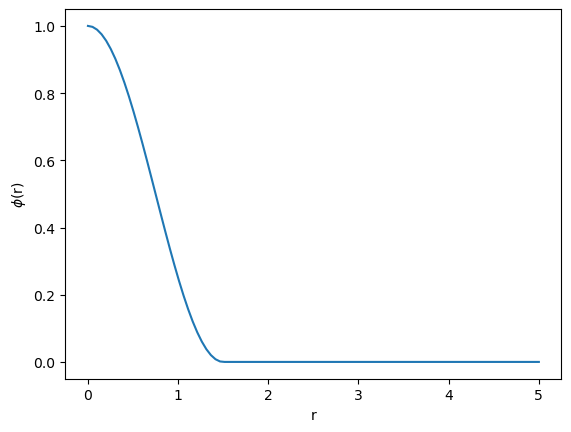

In [13]:
# Define a selection function with the form of a cosine
# That goes to 0 at the boundary

r_max_true = 1.5
phi_r_max = r_max_true

def phi(r):
    return ((np.cos(r * np.pi/phi_r_max) + 1)/2) * (r < phi_r_max)

plt.plot(np.linspace(0, 5, 100), phi(np.linspace(0, 5, 100)))
plt.xlabel("r")
plt.ylabel("$\phi$(r)")
plt.show()

In [14]:
n, n_prime, l = 100, 140, 0
# n, n_prime, l = 60, 20, 15

# Omega_matter used in inference
omega_matter = 0.315
r0OfR = getInterpolatedR0ofR(omega_matter_0, omega_matter)

# Accuracy settings
Nsplit = 10
epsabs = 1.49e-8

# W = calc_W(n, n_prime, l, r_max_0, r0OfR, phi, Nsplit, epsabs, plot=True)
# print(W)

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import spherical_jn

from utils import calc_n_max_l, computeIntegralSplit
from precompute_c_ln import get_c_ln_values_without_r_max
from precompute_sph_bessel_zeros import loadSphericalBesselZeros


c_ln_values_without_r_max = get_c_ln_values_without_r_max("c_ln.csv")
sphericalBesselZeros = loadSphericalBesselZeros("zeros.csv")


def calc_W_quad(n, n_prime, l, r_max, r0OfR, phiOfR0, Nsplit=10, epsabs=1.49e-8):
    k_ln = sphericalBesselZeros[l][n] / r_max
    k_ln_prime = sphericalBesselZeros[l][n_prime] / r_max


    def W_integrand(r):
        r0 = r0OfR(r)

        return phiOfR0(r0) * spherical_jn(l, k_ln_prime*r) * spherical_jn(l, k_ln*r0) * r*r

    integral = computeIntegralSplit(W_integrand, Nsplit, r_max, epsabs)

    return np.power(r_max, -3/2) * c_ln_values_without_r_max[l][n_prime] * integral


def calc_W_simpson(n, n_prime, l, r_max, r0OfR, phiOfR0, Npts=1001):
    k_ln = sphericalBesselZeros[l][n] / r_max
    k_ln_prime = sphericalBesselZeros[l][n_prime] / r_max


    def W_integrand(r):
        r0 = r0OfR(r)

        return phiOfR0(r0) * spherical_jn(l, k_ln_prime*r) * spherical_jn(l, k_ln*r0) * r*r

    x = np.linspace(0, r_max, Npts)
    y = W_integrand(x)

    integral = simpson(y, dx=(r_max / (Npts - 1)))

    return np.power(r_max, -3/2) * c_ln_values_without_r_max[l][n_prime] * integral

In [17]:
print("l = %d, n = %d, n' = %d" % (l, n, n_prime))
Nsplits_quad = [10, 100, 1000, 10000]
Npts_simpson = [1001, 10001, 100001, 1000001, 10000001, 2000001, 4000001]

print("Quad")
for Nsplit in Nsplits_quad:
    print(calc_W_quad(n, n_prime, l, r_max_0, r0OfR, phi, Nsplit))

print("Simpson")
for Npts in Npts_simpson:
    print(calc_W_simpson(n, n_prime, l, r_max_0, r0OfR, phi, Npts))

l = 0, n = 100, n' = 140
Quad
-9.667033891748017e-14
4.527720584792479e-19
1.3401365816470793e-19
-9.439795380084987e-20
Simpson
2.264453780645634e-19
3.6046407120481517e-19
3.7750885165511504e-20
-3.2931380349533235e-20
2.1938477193578642e-20
7.680735243432107e-21
-8.41063003722032e-21


In [ ]:
%timeit calc_W_quad(n, n_prime, l, r_max_0, r0OfR, phi, 10, epsabs)

33.1 ms ± 3.28 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
%timeit calc_W_quad(n, n_prime, l, r_max_0, r0OfR, phi, 100, epsabs)

98.5 ms ± 8.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
%timeit calc_W_simpson(n, n_prime, l, r_max_0, r0OfR, phi, 1001)

912 µs ± 102 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [ ]:
%timeit calc_W_simpson(n, n_prime, l, r_max_0, r0OfR, phi, 10001)

7.6 ms ± 693 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
%timeit calc_W_simpson(n, n_prime, l, r_max_0, r0OfR, phi, 100001)

72.6 ms ± 5.13 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
